In [7]:
import sys
sys.path.append("../../..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.util.setup import get_config, create_setting
from src.strategy import Strategy

In [8]:
def get_setting(setting, experiment, learn_alg, run=0):
    """ Get Strategy and Mechanism for specified experiment
    """
    num_runs = 10
    cfg, cfg_learner = get_config("experiment/soda_util/configs", setting, experiment, learn_alg)
    mechanism, game = create_setting(setting, cfg)
    name = (
                learn_alg + "_" + experiment + ("_run_" + str(run) if num_runs > 1 else "")
            )
    strategies = {}
    for i in game.set_bidder:
        strategies[i] = Strategy(i, game)
        strategies[i].load(name, setting, f"experiment/soda_util/")
    
    return mechanism, strategies, game


def get_bids(mechanism, strategies: dict, agent: str, number_o: int):
    """ Sample observation according to prior defined in mechanism and sample corresponding bids from computed strategy

    Args:
        mechanism: underlying mechanism
        strategies (dict): dict with strategies for all agents
        agent (str): agent/bidder
        n_o (int): number of observations/bids

    Returns:
        _type_: _description_
    """
    idx_agent = mechanism.bidder.index(agent)
    obs = mechanism.draw_values(number_o)[idx_agent]
    bids = strategies[agent].bid(obs)
    return obs, bids

def get_bne(mechanism, agent: str):
    """ Get BNE for given mechanism and agent

    Args:
        mechanism (_type_): _description_
        strategies (_type_): _description_
        agent (_type_): _description_

    Returns:
        _type_: _description_
    """
    lb, ub = mechanism.o_space[agent]
    x = np.linspace(lb+1e-5, ub-1e-5, 100)
    bne = mechanism.get_bne(agent, x)
    return x, bne


In [9]:
# parameter
param = {
        "fontsize_title": 14,
        "fontsize_legend": 13,
        "fontsize_label": 12,
    }

marker = dict(zip(range(3), ['o','s','v']))
colors = {0: "#003f5c", 
          1: "#bc5090",
          2: "#ffa600",
}
number_o = 150
markersize = 20

dpi = 150
save = False

In [10]:
def set_axis(xlim, ylim, title, param, xlabel: str="Observation o", ylabel: str="Bid b", dpi=dpi):
    """ General settings for axis
    """
    fig = plt.figure(tight_layout=True, dpi=dpi)
    ax = fig.add_subplot(111)
    ax.set_xlabel(xlabel, fontsize=param["fontsize_label"])
    ax.set_ylabel(ylabel, fontsize=param["fontsize_label"])
    ax.grid(linestyle="-", linewidth=0.25, color="lightgrey", zorder=-10, alpha=.5)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_title(title, fontsize=param["fontsize_title"])
    ax.set_aspect('equal')
    return fig, ax


# Single Item Model

own gradient
File: "soma_eucl_fp2_QL_FP_2_gaussian_run_0_agent_1.npy" is not available in directory "/home/mathe/code/soda/experiment/soda_util/strategies/single_item/"


ValueError: x, y, and format string must not be None

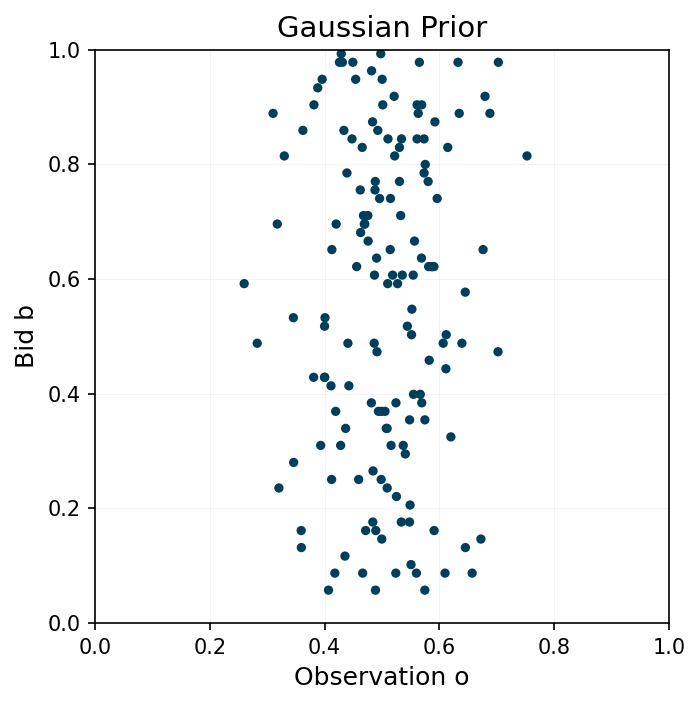

In [11]:
setting = "single_item"
exp = "QL_FP_2_gaussian"
learner = "soma_eucl_fp2"

mechanism, strategies, _ =  get_setting(setting, exp, learner, run=0)
obs, bids = get_bids(mechanism, strategies, '1', number_o)
x, bne = get_bne(mechanism, '1')

fig, ax = set_axis((0,1), (0,1), 'Uniform Prior', param)

# plot strategy & BNE
ax.scatter(obs, bids, facecolors=colors[0], edgecolors='none', marker=marker[0], s=markersize, zorder=2, alpha=1)
ax.plot(x, bne, color=colors[0], linestyle='-', zorder=1)

# legend
ax.scatter([], [], facecolors=colors[0], edgecolors='none', marker=marker[0], s=40,  label='$\mathrm{SODA}_1$')
ax.plot([],[], label='analyt. BNE', color=colors[0], linestyle='-', linewidth=2)
ax.legend(fontsize=param["fontsize_legend"], loc=2)

if save:
    fig.savefig(f'plots/{exp}.pdf', bbox_inches='tight')

# Runtime

In [ ]:
df = pd.read_csv('../../runtime/log/single_item/log_learn_agg.csv')

In [ ]:
experiments = ['fpsb_discr016', 'fpsb_discr032', 'fpsb_discr064', 'fpsb_discr128']
discr = [16, 32, 64, 128]
versions = ['fast', 'slow']

mean, std = {}, {}
for agents in [2, 3, 10]:
    for v in versions:
        if (agents == 10) & (v == 'slow'):
            pass
        else:
            mean[f"{agents}_{v}"] = np.array([df[(df.experiment==f"{exp}_{agents}_{v}")&(df.Metric == "iter/sec")].Mean.item() for exp in experiments])**(-1)
            std[f"{agents}_{v}"] = np.array([df[(df.experiment==f"{exp}_{agents}_{v}")&(df.Metric == "iter/sec")].Std.item() for exp in experiments])

In [ ]:
ls = {2: '-', 3:'--', 10:':'}

fig = plt.figure(tight_layout=True, dpi=dpi)
ax = fig.add_subplot(111)
ax.set_xlabel('Discretization N,M', fontsize=param["fontsize_label"])
ax.set_ylabel('Iter. per second', fontsize=param["fontsize_label"])
ax.grid(linestyle="-", linewidth=0.25, color="lightgrey", zorder=-10, alpha=.5)
ax.set_title('Runtime SODA', fontsize=param["fontsize_title"])

for agents in [2, 3, 10]:
    for v in versions:
        if (agents == 10) & (v == 'slow'):
            pass
        else:
            ax.plot(discr, mean[f"{agents}_{v}"], color=colors[versions.index(v)], linestyle=ls[agents])
            #ax.fill_between(discr, mean[f"{agents}_{v}"]-std[f"{agents}_{v}"] ,mean[f"{agents}_{v}"] +std[f"{agents}_{v}"] , color=colors[versions.index(v)], zorder=1, alpha=0.3)

# Variational Stability

In [ ]:
from src.util.metrics import get_bne_fpsb
from src.game import discr_spaces

In [ ]:
example = 'fpsb_example'
mechanism, strategies, game = get_setting('single_item', example,'soda_entro_example')
strategies = {'1': Strategy('1', game)}
game.o_discr['1'] = discr_spaces(mechanism.o_space['1'], game.n, False)
game.a_discr['1'] = discr_spaces(mechanism.a_space['1'], game.m, False)


In [ ]:
strategies['1'].x = get_bne_fpsb(game.n, True)

grad = mechanism.compute_gradient(game, strategies, '1')
br = [ np.where(g==g.max())[0].min() for g in grad ]


fig, ax = set_axis((0, 1), (0, 1), 'BNE 1', param)
ax.imshow(strategies['1'].x.T, extent=(0, 1, 0, 1), origin="lower", vmin=0, cmap="Greys", zorder=2)
ax.scatter(strategies['1'].o_discr, strategies['1'].a_discr[br], marker='s', s=50, edgecolors=colors[2], c='none', linewidths=2, zorder=3)


ax.scatter([], [], marker='s', s=110, c='k', label=r'BNE $s^*$')
ax.scatter([], [], marker='s', s=110, c='none', edgecolors=colors[2],  label=r'Best Response $s^{br}$', linewidths=2)
ax.legend(fontsize=param["fontsize_legend"], loc=2)

if save:
    fig.savefig(f'plots/{example}_bne1.pdf', bbox_inches='tight')

In [ ]:
strategies['1'].x = get_bne_fpsb(game.n, False)

grad = mechanism.compute_gradient(game, strategies, '1')
br = [ np.where(g==g.max())[0].max() for g in grad ]

fig, ax = set_axis((0, 1), (0, 1), 'BNE 2', param)
ax.imshow(strategies['1'].x.T, extent=(0, 1, 0, 1), origin="lower", vmin=0, cmap="Greys", zorder=2)
ax.scatter(strategies['1'].o_discr, strategies['1'].a_discr[br], marker='s', s=50, edgecolors=colors[2], c='none', linewidths=2, zorder=3)


ax.scatter([], [], marker='s', s=100, c='k', label=r'BNE $s^*$')
ax.scatter([], [], marker='s', s=100, c='none', edgecolors=colors[2],  label=r'Best Response $s^{br}$', linewidths=2)
ax.legend(fontsize=param["fontsize_legend"], loc=2)

if save:
    fig.savefig(f'plots/{example}_bne2.pdf', bbox_inches='tight')

In [ ]:
strategies['1'].x = get_bne_fpsb(game.n, True)

c = np.arange(game.n)//4

fig, ax = set_axis((0, 1), (0, 1), 'Collusive Strategy', param)
ax.imshow(strategies['1'].x.T, extent=(0, 1, 0, 1), origin="lower", vmin=0, cmap="Greys", zorder=2)
ax.scatter(strategies['1'].o_discr, strategies['1'].a_discr[c], marker='s', s=50, c=colors[1], zorder=3)

ax.scatter([], [], marker='s', s=100, c='k', label=r'BNE 1 $s^*$')
ax.scatter([], [], marker='s', s=100, c=colors[1],  label=r'Collusive Strategy $s^c$', linewidths=2)
ax.legend(fontsize=param["fontsize_legend"], loc=2)
if save:
    fig.savefig(f'plots/{example}_collusive.pdf', bbox_inches='tight')